## Spectrogram 분석  
wav파일과 spectrogram의 성능 비교를 위한 spectrgram을 통한 classification을 만들어본다.  
항상 그렇듯 전처리 - 모델구성 - 학습 - 테스트 순서로 이루어 지는데, 먼저 데이터를 받아와야한다.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'#npz형태로 저장되어 있는 파일을 받아온다
speech_data = np.load(data_path)
print("✅")

✅


데이터를 받아왔다면 이제 데이터를 확인 차례다.  
## 1. 전처리

In [2]:
import IPython.display as ipd
import random
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]#난수 번째의 wav를 data에 넣는다
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)#ipd 라이브러리를 통해 data를 확인한다.

rand num :  12804
Wave data shape :  (8000,)
label :  ['right']


데이터를 확인했으니, 이제는 target(label)을 할당 해줘야한다.  

In [3]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
#음성의 내용
label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):#enumerate를 통한 인덱싱
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


위에서 target의 리스트를 만들어 주었으니 실제 사용할 label리스트를 행렬로 만들어 넣어준다

In [4]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

label_data에 행렬의 모습으로 데이터가 들어갔다.

위에서 전처리한 데이터들은 <strong>wav의 1차원 데이터</strong>이고, 목적은 spectogram을 이용한 분석이기  
때문에 이를 위한 함수를 만들어준다

In [5]:
import librosa#spectogram을 만들어주는 librosa 라이브러리

def wav2spec(wav, fft_size=258):#입력받은 wav를 
    D = np.abs(librosa.stft(wav, n_fft=fft_size))#fast furier transform을 통해 2차원 
                                                #데이터로 만들어준다.
    return D
print("✅")

✅


spectogram이 wav로 부터 잘 만들어지는지 확인해본다.

In [6]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print(type(spec))
print("Waveform shape : ",data.shape)#==rate ==srt
print("Spectrogram shape : ",spec.shape)

<class 'numpy.ndarray'>
Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


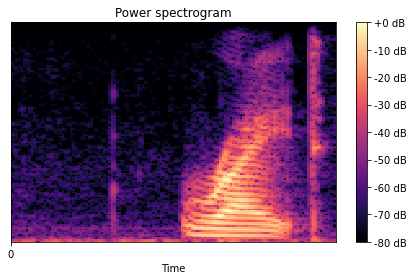

In [7]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
#x축은 시간, y축은 dB
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

잘 만들어진 것이 확인되었다. 이제는 date set과 train set을 만들어줄 차례인데  
이곳에서 정말 고생했던 것 같다.

In [9]:
from sklearn.model_selection import train_test_split

train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], label_data, test_size=0.1, shuffle=True)
del speech_data


원래는 먼저 spectogramize를 진행한 데이터들을 train_test_split으로 나눠주고 싶었는데,  
이렇게 해도 에러, 저렇게 해도 에러가 발생해서 결국에는 나눠주고, 나눠진 test, train set을 각각 아래에서 정의해준 spectogramize함수를 통해 각각 spectrogram으로 변형해 주었다.

In [10]:
def spectrogramize(speech_data):
    spectrograms = []
    
    for i in speech_data:
        spectograms.append(wav2spec(i))
        
    spectograms = np.array(spectograms)
    return spectograms

train_wav = spectrogramize(train_wav) 
test_wav = spectrogramize(test_wav)

이렇게 만들어진 데이터들을 다시 확인했다.  
이로서 전처리는 완료!

In [20]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")


train data :  (45558, 130, 126, 1)
train labels :  (45558,)
test data :  (5062, 130, 126, 1)
test labels :  (5062,)
✅


## 2. 모델 구성  
전처리를 완료한 다음 해야할 것은 모델 구성이다.  
먼저 어느 정도를 잘라서 이용할 것인지 batch_size를 지정해주고  
그 다음으로는 epoch를 지정해준다.

In [13]:
batch_size = 32
max_epochs = 10

checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'
#check point는 함수가 저장한 가중치를 다시불러올 수 있게끔 한다!

'/home/aiffel-dj16/aiffel/speech_recognition/models/wav'

In [14]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    #one_hot은 인덱스를 입력받아 인코딩 결과를 리턴한다
    return wav, label
print("✅")

✅


--------------------------  
## one hot?? 
one hot encoding이라는 개념이 다소 생소해서 찾아보게 됐다.  
one hot은 <span style = "color : blue">단어 집합의 크기를 벡터의 차원으로 변형</span>하고, 표현하고 싶은 단어의 인덱스에  <span style = "color : blue">1의 값</span>을, 나머지 다른 인덱스에는 <span style = "color : blue">0의 값</span>을 부여하는 __<span style = "color : blue">단어의 벡터 표현 방식</span>__ 이라고한다.  
딥러닝과 머신러닝에 필수적이라고 하니 따로 알아봐야겠다는 생각이 들었다.  
--------------------------

In [21]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
#dataset을 생성하는 함수. tensor로 부터 slices를 생성한다.
#어떤 데이터가(350, 100, 100)입력된다면, 100x100의 크기를 갖는 350개의 slice가 생성되는것
train_dataset = train_dataset.map(one_hot_label)#단어 -> 벡터 인코딩!
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
#repeat(step) step에는 원하는 epoch를 넣을 수 있고 넣어주지 않는다면 iteration이 무한정
#돌아간다.
#batch는 batchsize를 설정한다.
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


전처리를 완료하고 학습을 위한 모델을 구성해줘야한다.

In [16]:
train_wav = train_wav.reshape(-1, sr, 126, 1)
#위의 batch된 데이터들과 맞춰준다
#-1옵션은 size를 기반으로 row의 개수를 선정한다
test_wav = test_wav.reshape(-1, sr, 126, 1)

from tensorflow.keras import layers
input_tensor = layers.Input(shape=(sr, sc, 1))


x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,#checkpoint의 가중치
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)


## Callback??  
위에서 checkpoint를 만들어준 이유!  
model.fit함수를 이용할 때 callback함수를 이용해서 <strong><span style = "color : blue">학습 중간에 원하는 동작을 하게끔 설정</span></strong>할 수 있다!

## 3. 학습

In [17]:
history_wav = model_wav.fit(train_dataset,
                            epochs=max_epochs,
                            steps_per_epoch=len(train_wav) // batch_size,
                            validation_data=test_dataset,#validation 까지 진행!
                            validation_steps=len(test_wav) // batch_size,
                            callbacks=[cp_callback]
                            )

Epoch 1/10
1422/1423 [============================>.] - ETA: 0s - loss: 0.8368 - accuracy: 0.7345
Epoch 00001: val_loss improved from inf to 0.33785, saving model to /home/aiffel-dj16/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 66s 46ms/step - loss: 0.8364 - accuracy: 0.7346 - val_loss: 0.3378 - val_accuracy: 0.8954
Epoch 2/10
1422/1423 [============================>.] - ETA: 0s - loss: 0.2765 - accuracy: 0.9172
Epoch 00002: val_loss improved from 0.33785 to 0.23806, saving model to /home/aiffel-dj16/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 66s 46ms/step - loss: 0.2764 - accuracy: 0.9172 - val_loss: 0.2381 - val_accuracy: 0.9244
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1763 - accuracy: 0.9474
Epoch 00003: val_loss improved from 0.23806 to 0.16463, saving model to /home/aiffel-dj16/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 66s 47ms/step 

## 3-1 학습 결과

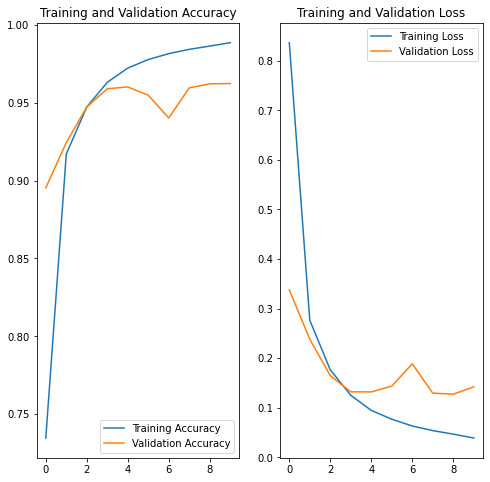

In [18]:
acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']
loss = history_wav.history['loss']
val_loss = history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

x축은 epoch, y축은 accuracy로 epoch가 높아짐에 따라 변화를 한 눈에 확인할 수 있다

## 4. 테스트

In [19]:
model_wav.load_weights(checkpoint_dir)
results = model_wav.evaluate(test_dataset)

print("loss value: {:.3f}".format(results[0]))             # loss
print("accuracy value: {:.4f}%".format(results[1] * 100))  # accuracy


159/159 [==============================] - 26s 165ms/step - loss: 0.1270 - accuracy: 0.9623
loss value: 0.127
accuracy value: 96.2268%


## 5. 마치고  
1차원의 데이터를 2차원으로 변형하는 첫 토이 프로젝트였다. 생소한만큼 몇일 간(시간은적지만)  
어떻게 접근할지 생각하는 것 만 으로도 솔직히 힘들었다.. 전처리를 어떻게 해결하고 나니 그다음에는 학습시키기 위한 데이터의 차원과 형식을 맞추는 것도 막막했던 것 같다.  
지금까지 이미지, 텍스트, 음성의 데이터들로 진행해 보았는데 아직까지는 딥러닝이 어떻게 흘러가는구나 정도로 이해할 수 있었고 완벽히 이해하는데 까지는 다소 시간이 걸릴 것으로 느껴진다.(사실 조금은 막막하다.) 그래도 토이프로젝트를 진행하면서 코드를 뜯다보니 어느정도의 인사이트는 생긴 것 같아서 내심 뿌듯한 기분도 든다. 완벽한 이미지라고 할 수는 없지만 음성 데이터를 이미지 데이터로 바꾸는 프로젝트를 진행하니 다음에는 어떤 새로운 형태의 데이터를 전처리해야할지, 어떤 모델을 만나게 될지 두렵고도 기대된다! 